In [17]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import ale_py
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

In [18]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

# env = gym.make('LunarLander-v3')
env = gym.make('CartPole-v1')

In [19]:
class DNN(nn.Module):
    def __init__(self, input_dim, n_actions):
        super(DNN, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, n_actions),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, x):
        return self.net(x)

class PolicyGradientAgent():
    def __init__(self, state_shape, n_actions, device="cpu"):
        self.device = device
        self.n_actions = n_actions
        self.state_shape = state_shape
        self.lr=1e-2

        self.policy_net = DNN(state_shape, n_actions).to(device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), self.lr)
    
        self.gamma = 0.99

    def select_action(self, state):
        with torch.no_grad():
            state = torch.FloatTensor(state).to(self.device)
            probs = self.policy_net(state)
            action = torch.distributions.Categorical(probs).sample()
        return action.item()
        

    def train_pg(self, env, n_episodes=1000, temporal=False, advantage=False):
        device = self.device
        running_loss_size = 10
        all_rewards, all_losses = [], []
        best_reward = -np.inf
        for episode in range(n_episodes):
            rewards, states, actions = [], [], []
            with torch.no_grad():
                state, _ = env.reset()
                done, truncated = False, False
                while not (done or truncated):
                    states.append(torch.from_numpy(state).float().to(device))
                    action = self.select_action(state)
                    next_state, reward, done, truncated, _ = env.step(action)
                    rewards.append(reward)
                    actions.append(action)
                    state = next_state

            discounted_rewards = []
            running_add = 0
            for r in reversed(rewards):
                running_add = r + self.gamma * running_add
                discounted_rewards.insert(0, running_add)
            discounted_rewards = torch.FloatTensor(discounted_rewards).to(device)
            states = torch.stack(states)
            actions = torch.tensor(actions).to(device)
            probs = self.policy_net(states)
            probs = probs[range(len(probs)), actions]
            returns = discounted_rewards
            if temporal:
                loss = -torch.sum(torch.log(probs) * returns)
            else:
                loss = -torch.sum(torch.log(probs) * returns[0])

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            episode_reward = sum(rewards)
            all_rewards.append(episode_reward)
            all_losses.append(loss.item())

            print(f"Episode {episode + 1}, Reward: {np.mean(all_rewards[-100:])}")

            if np.mean(all_rewards[-100:]) >= 195:
                print(f"Solved in {episode + 1} episodes!")
                break
        return all_rewards, all_losses



In [20]:
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

# print(state_dim, n_actions)
agent_non_temporal_non_advantage = PolicyGradientAgent(state_dim, n_actions, device)


In [21]:
rewards, losses = agent_non_temporal_non_advantage.train_pg(env, n_episodes=5000)

Episode 1, Reward: 43.0
Episode 2, Reward: 26.0
Episode 3, Reward: 26.333333333333332
Episode 4, Reward: 22.5
Episode 5, Reward: 20.0
Episode 6, Reward: 20.0
Episode 7, Reward: 19.857142857142858
Episode 8, Reward: 19.0
Episode 9, Reward: 18.444444444444443
Episode 10, Reward: 18.0
Episode 11, Reward: 18.363636363636363
Episode 12, Reward: 19.333333333333332
Episode 13, Reward: 18.76923076923077
Episode 14, Reward: 18.142857142857142
Episode 15, Reward: 17.666666666666668
Episode 16, Reward: 17.1875
Episode 17, Reward: 16.705882352941178
Episode 18, Reward: 16.5
Episode 19, Reward: 16.36842105263158
Episode 20, Reward: 16.05
Episode 21, Reward: 16.095238095238095
Episode 22, Reward: 15.954545454545455
Episode 23, Reward: 15.91304347826087
Episode 24, Reward: 15.708333333333334
Episode 25, Reward: 15.88
Episode 26, Reward: 16.0
Episode 27, Reward: 15.74074074074074
Episode 28, Reward: 15.892857142857142
Episode 29, Reward: 15.689655172413794
Episode 30, Reward: 15.7
Episode 31, Reward: 

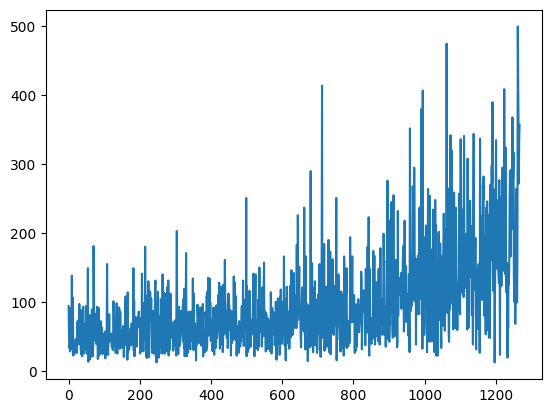

In [7]:
plt.plot(rewards)

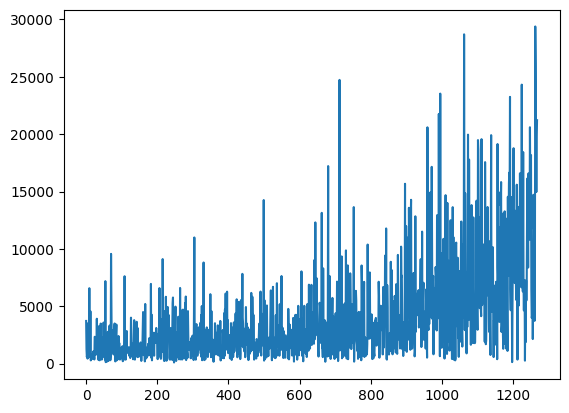

In [8]:
plt.plot(losses)

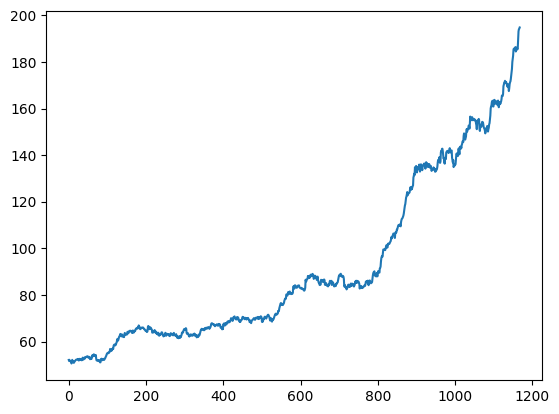

In [11]:
# plot mean rewards over a window of 100 episodes
plt.plot([np.mean(rewards[i-100:i]) for i in range(100, len(rewards))]) 


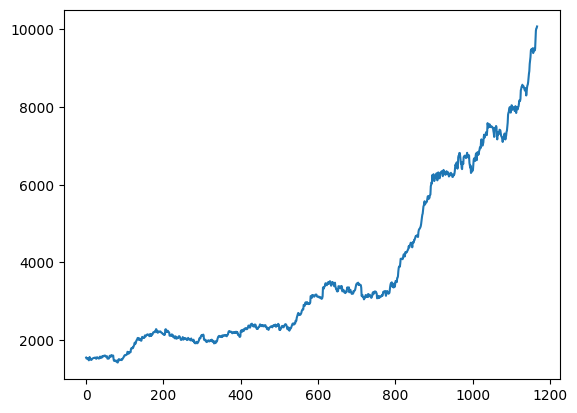

In [12]:
plt.plot([np.mean(losses[i-100:i]) for i in range(100, len(rewards))]) 

In [ ]:
# save the model
torch.save(agent_non_temporal_non_advantage.policy_net.state_dict(), "pg_agent_non_temporal_non_advantage_cartpole_model.pth")

In [14]:
# save the rewards and losses
np.save("pg_cartpole_rewards.npy", rewards)
np.save("pg_cartpole_losses.npy", losses)